In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
sub_df = pd.read_csv("sample_submission.csv")

In [3]:
data_train.shape
data_test.shape

(4277, 13)

In [4]:
data_train.isnull().mean()*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [5]:
data_test.isnull().mean()*100

PassengerId     0.000000
HomePlanet      2.034136
CryoSleep       2.174421
Cabin           2.338087
Destination     2.151040
Age             2.127660
VIP             2.174421
RoomService     1.917232
FoodCourt       2.478373
ShoppingMall    2.291326
Spa             2.361468
VRDeck          1.870470
Name            2.197802
dtype: float64

In [6]:
list_of_numerics = data_train.select_dtypes(include=['float','int']).columns
types = data_train.dtypes
missing = round((data_train.isnull().sum()/data_train.shape[0]),3)*100
overview = data_train.apply(lambda x: [round(x.min()), 
 round(x.max()), 
 round(x.mean()), 
 round(x.quantile(0.5))] if x.name in list_of_numerics else x.unique())

outliers = data_train.apply(lambda x: sum(
 (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25))))|
 (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25))))
 if x.name in list_of_numerics else ''))


explo = pd.DataFrame({'Types': types,
  'Missing%': missing,
  'Overview': overview,
  'Outliers': outliers}).sort_values(by=['Missing%','Types'],ascending=False)
explo.transpose()

,CryoSleep,ShoppingMall,HomePlanet,Cabin,VIP,Name,VRDeck,Destination,Age,RoomService,FoodCourt,Spa,PassengerId,Transported
Types,object,float64,object,object,object,object,float64,object,float64,float64,float64,float64,object,bool
Missing%,2.5,2.4,2.3,2.3,2.3,2.3,2.2,2.1,2.1,2.1,2.1,2.1,0.0,0.0
Overview,"[False, True, nan]","[0, 23492, 174, 0]","[Europa, Earth, Mars, nan]","[B/0/P, F/0/S, A/0/S, F/1/S, F/0/P, F/2/S, G/0...","[False, True, nan]","[Maham Ofracculy, Juanna Vines, Altark Susent,...","[0, 24133, 305, 0]","[TRAPPIST-1e, PSO J318.5-22, 55 Cancri e, nan]","[0, 79, 29, 27]","[0, 14327, 225, 0]","[0, 29813, 458, 0]","[0, 22408, 311, 0]","[0001_01, 0002_01, 0003_01, 0003_02, 0004_01, ...","[False, True]"
Outliers,0,1829,0,0,0,0,1809,0,77,1861,1823,1788,0,0


In [7]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


### EDA

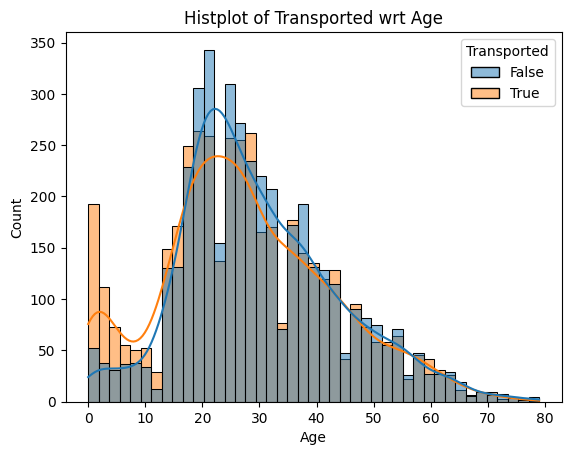

In [8]:
sns.histplot(x = 'Age', hue = 'Transported', data = data_train, kde = True)
plt.title('Histplot of Transported wrt Age')
plt.show()

In [9]:
median_age = data_train['Age'].median()
data_train['Age'] = data_train['Age'].fillna(median_age)

In [10]:
data_train.isnull().mean()*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             0.000000
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

We could probably use thershould leverage because we see that younf people clearly are more concerned

In [11]:
bins = [0, 18, 50, float('inf')] 
labels = ['young', 'adult', 'old']

data_train['age_group'] = pd.cut(data_train['Age'], bins=bins, labels=labels)
data_test['age_group'] = pd.cut(data_test['Age'], bins = bins, labels = labels)

# One-hot encode the 'age_group' variable
#data_train = pd.get_dummies(data_train, columns=['age_group'], prefix=['age_group'])

data_train.drop(['Age'], axis = 1, inplace = True)
data_test.drop(['Age'], axis = 1, inplace = True)

<AxesSubplot: xlabel='age_group', ylabel='count'>

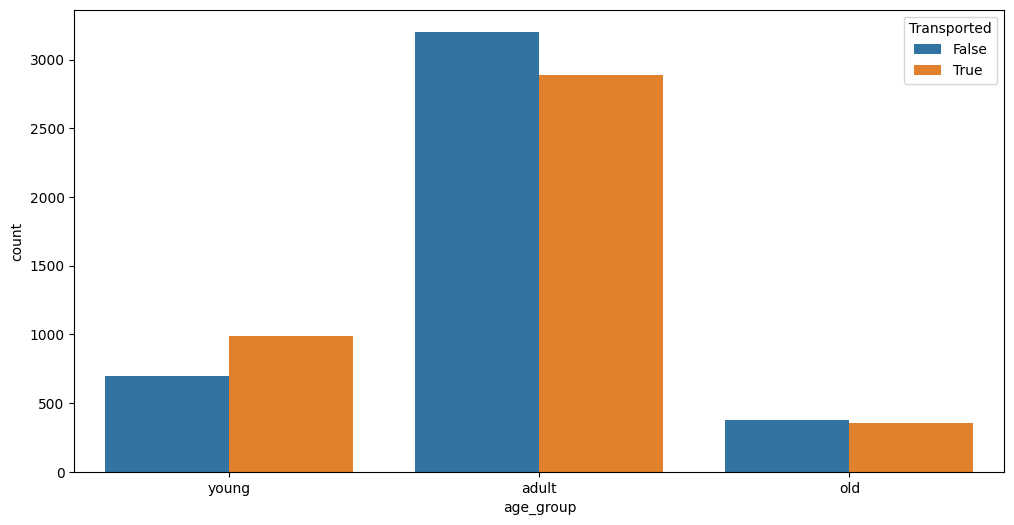

In [12]:
sorted(data_train["age_group"].value_counts().keys().to_list())
plt.figure(figsize=(12,6))
sns.countplot(x=data_train["age_group"],hue="Transported",data=data_train)

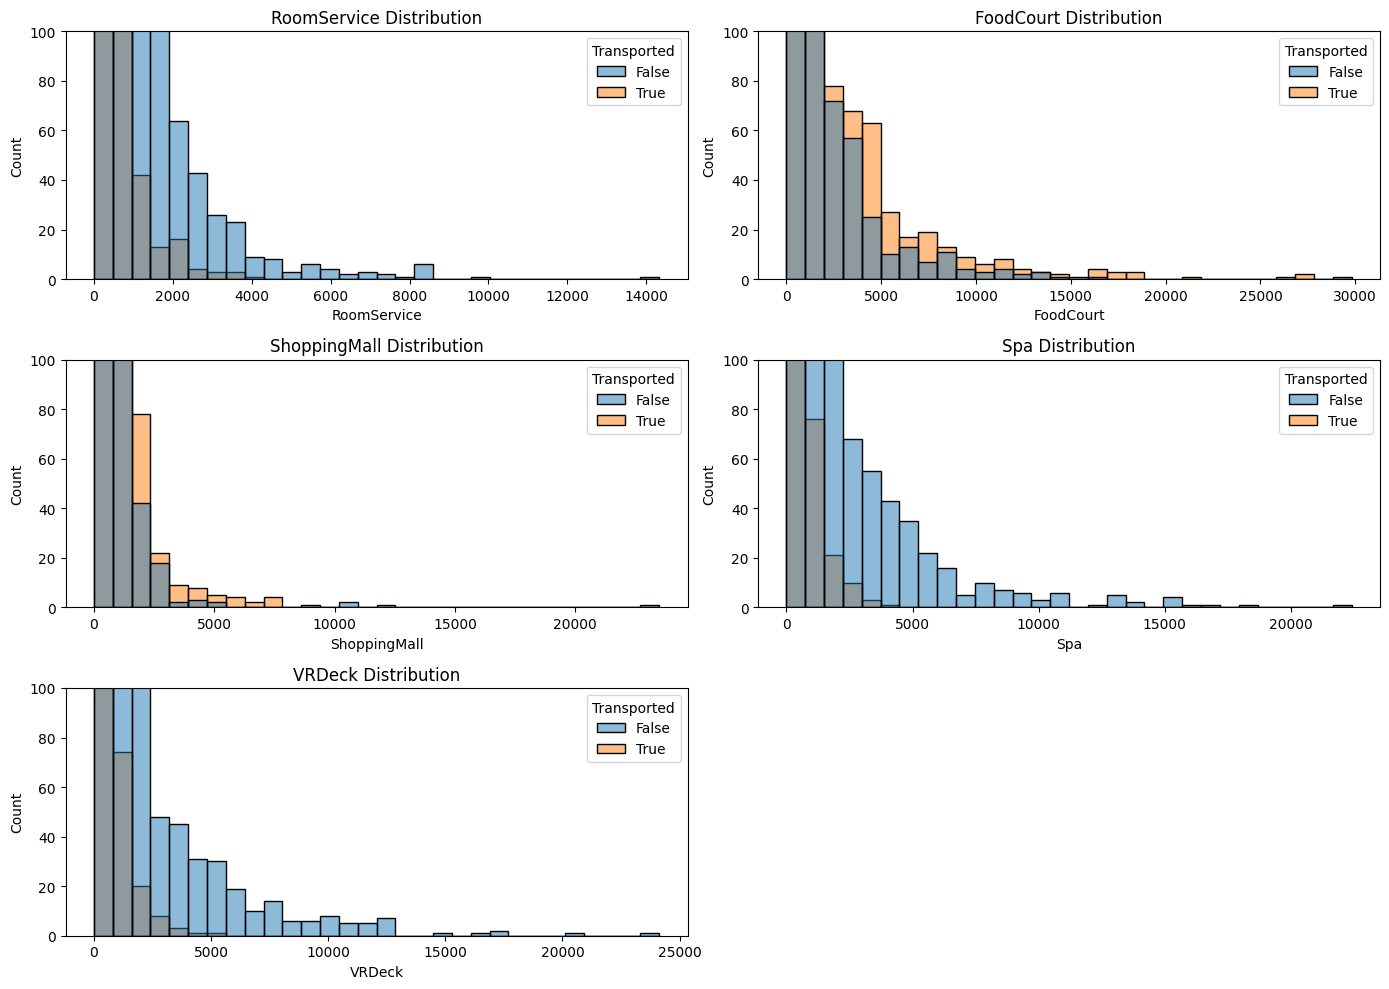

In [13]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data = data_train,bins=30)
    plt.title(f"{column} Distribution")
    plt.ylim(0,100)
    plt.tight_layout()

All this columns represents the same thing, let us create a variable that gather everything

In [14]:
data_train['Expenses'] = data_train[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].sum(axis=1)
data_test['Expenses'] = data_test[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].sum(axis=1)

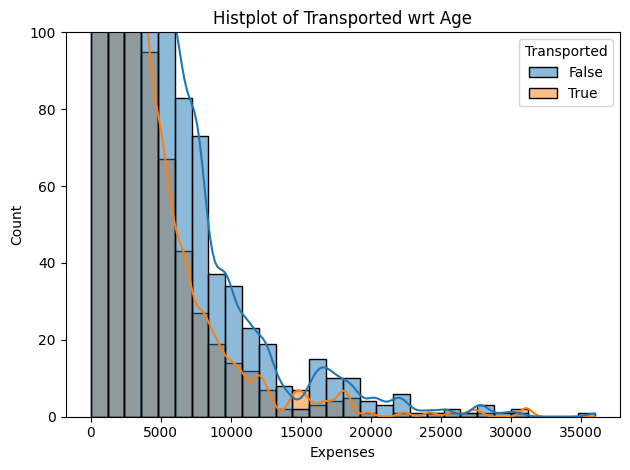

In [15]:
sns.histplot(x = 'Expenses', hue = 'Transported', data = data_train,bins = 30, kde = True)
plt.title('Histplot of Transported wrt Age')
plt.ylim(0,100)
plt.tight_layout()
plt.show()

In [16]:
data_train['zero_expense'] = data_train['Expenses'] == 0
data_test['zero_expense'] = data_test['Expenses'] == 0

<AxesSubplot: xlabel='zero_expense', ylabel='count'>

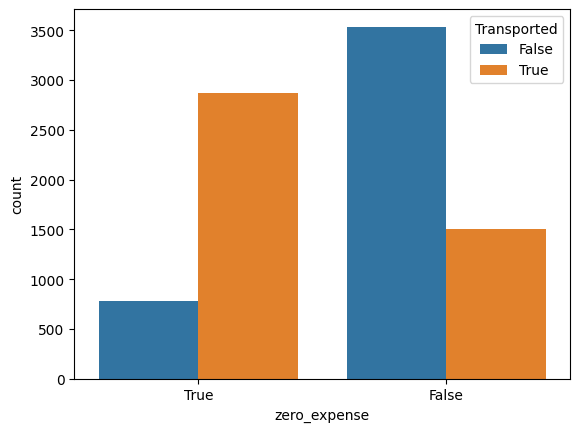

In [17]:
sns.countplot(x="zero_expense", hue="Transported", order = [True, False], data=data_train)

In [18]:
#Check the missing variables in our new feature
data_train['Expenses'].isnull().mean()*100

0.0

In [19]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0
Expenses,8693.0,1440.866329,2803.045694,0.0,0.0,716.0,1441.0,35987.0


In [20]:
data_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,age_group,Expenses,zero_expense
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,adult,0.0,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,adult,736.0,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,old,10383.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,adult,5176.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,young,1091.0,False


How can we understand the passenger ID

In [21]:
def expand_Id(df):
    df[['Group', 'Number']] = df['PassengerId'].str.split('_', expand=True)
    df['Number'] = pd.to_numeric(df['Number'])
    df['PeopleInGroup'] = df.groupby('Group')['Number'].transform('max')
    df['solo'] = df['PeopleInGroup'] == 1
    df.drop(['PassengerId', 'Number'], axis = 1, inplace=True)

In [22]:
expand_Id(data_train)

In [23]:
expand_Id(data_test)

In [24]:
data_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,age_group,Expenses,zero_expense,Group,PeopleInGroup,solo
0,Europa,False,B/0/P,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,adult,0.0,True,0001,1,True
1,Earth,False,F/0/S,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,adult,736.0,False,0002,1,True
2,Europa,False,A/0/S,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,old,10383.0,False,0003,2,False
3,Europa,False,A/0/S,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,adult,5176.0,False,0003,2,False
4,Earth,False,F/1/S,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,young,1091.0,False,0004,1,True


<AxesSubplot: xlabel='solo', ylabel='count'>

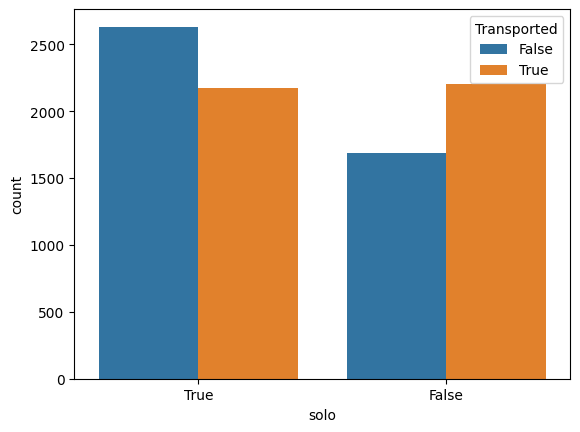

In [25]:
sns.countplot(x='solo', hue='Transported', order=[True, False], data=data_train)

We keep this one, not solo peaople are more likely to be transported

How can we understand the feature 'Cabin'?

In [26]:
def expand_Cabin(df):
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Num'] = pd.to_numeric(df['Num'])
    bins = [0, 300, 600, 900, 1200, float('inf')] 
    labels = ['0-300', '3000-600', '600-900', '900-1200', '1200-']
    df['num_group'] = pd.cut(df['Num'], bins=bins, labels=labels)
    df.drop(['Num'], axis = 1, inplace = True)
    df.drop(['Cabin'], axis = 1, inplace = True)

In [27]:
expand_Cabin(data_train)
expand_Cabin(data_test)

Is the number an important feature?

<AxesSubplot: xlabel='num_group', ylabel='count'>

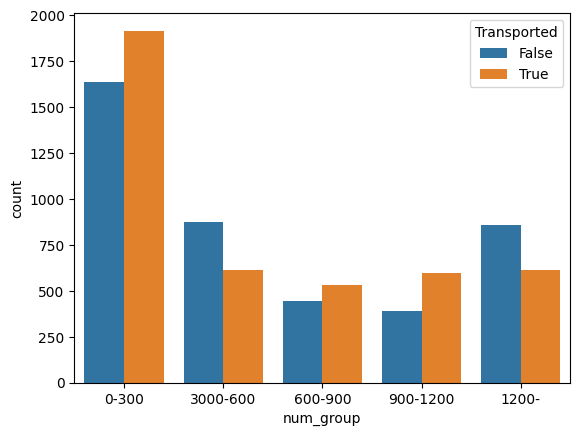

In [28]:
sns.countplot(x='num_group', hue='Transported', data=data_train)

<AxesSubplot: xlabel='Deck', ylabel='count'>

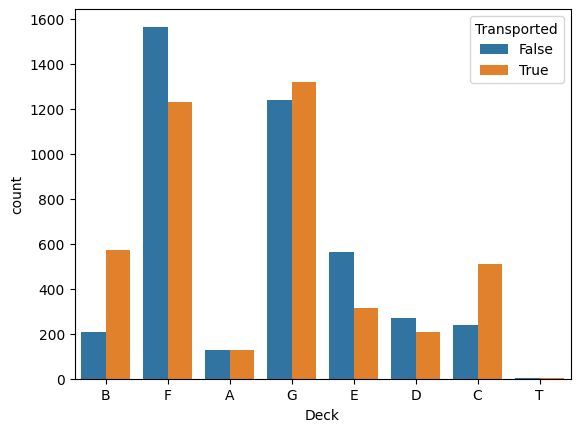

In [29]:
sns.countplot(x='Deck', hue='Transported', data=data_train)

<AxesSubplot: xlabel='Side', ylabel='count'>

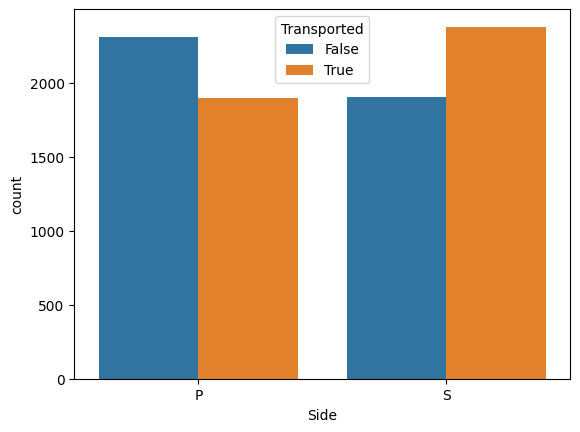

In [30]:
sns.countplot(x='Side', hue='Transported', data=data_train)

### What about the Home Planet?

<AxesSubplot: xlabel='HomePlanet', ylabel='count'>

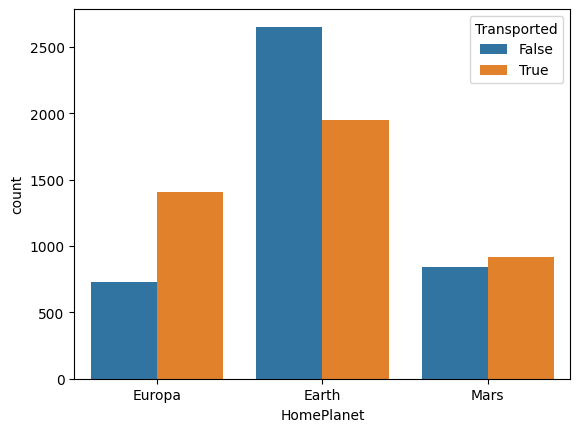

In [31]:
sns.countplot(x='HomePlanet', hue='Transported', data=data_train)

### What about the Destination?

<AxesSubplot: xlabel='Destination', ylabel='count'>

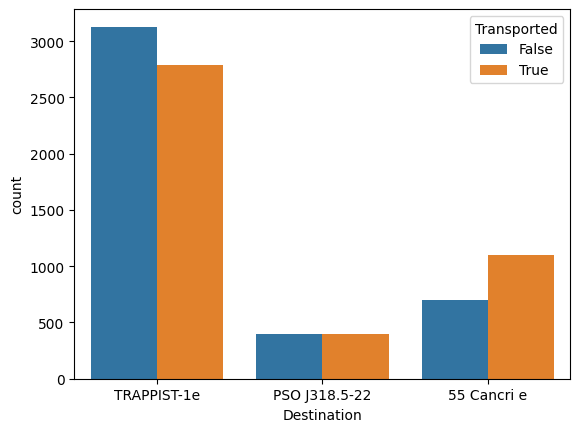

In [32]:
sns.countplot(x='Destination', hue='Transported', data=data_train)

### Of course VIP should play a role

<AxesSubplot: xlabel='VIP', ylabel='count'>

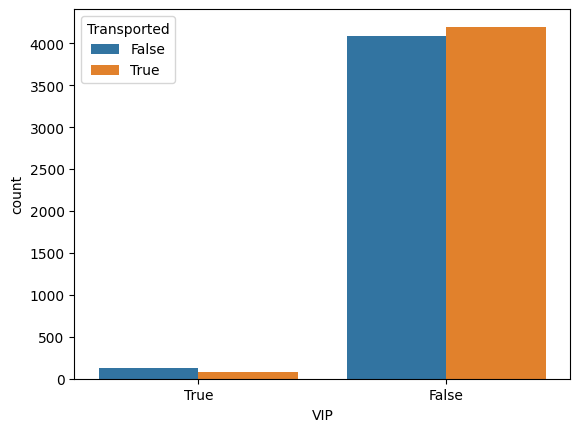

In [33]:
sns.countplot(x='VIP', hue='Transported', order = [True, False], data=data_train)

Data is too much unbalanced to decide, we keep the variable

### We now need to deal with missing data

In [34]:
d=data_train.isnull().sum()[data_train.isnull().sum()>0].to_frame().rename(columns={0:"No. of Missing values"})
d["%missing_value"]=round(data_train.isnull().sum()[data_train.isnull().sum()>0]/data_train.shape[0]*100,2)
d

,No. of Missing values,%missing_value
HomePlanet,201,2.31
CryoSleep,217,2.50
Destination,182,2.09
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11
VRDeck,188,2.16
Name,200,2.30


In [35]:
cat_cols = data_train.select_dtypes(include=["object","bool","category"]).columns.tolist()
cat_cols.remove("Transported")
num_cols = data_train.select_dtypes(include=["int","float"]).columns.tolist()
def fill_missing(df):
    imputer1 = SimpleImputer(strategy='most_frequent') #, fill_value=df[cat_cols].mode().iloc[0])
    imputer2= SimpleImputer(strategy="median")
    #df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[num_cols] = imputer2.fit_transform(df[num_cols])

In [36]:
fill_missing(data_train)
fill_missing(data_test)

In [37]:
print(data_train.dtypes)

HomePlanet        object
CryoSleep         object
Destination       object
VIP               object
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name              object
Transported         bool
age_group         object
Expenses         float64
zero_expense      object
Group             object
PeopleInGroup    float64
solo              object
Deck              object
Side              object
num_group         object
dtype: object


In [38]:
data_train.isnull().mean()*100

HomePlanet       0.0
CryoSleep        0.0
Destination      0.0
VIP              0.0
RoomService      0.0
FoodCourt        0.0
ShoppingMall     0.0
Spa              0.0
VRDeck           0.0
Name             0.0
Transported      0.0
age_group        0.0
Expenses         0.0
zero_expense     0.0
Group            0.0
PeopleInGroup    0.0
solo             0.0
Deck             0.0
Side             0.0
num_group        0.0
dtype: float64

In [39]:
data_train.drop(['Name'], axis = 1, inplace= True)
data_test.drop(['Name'], axis = 1, inplace= True)

In [40]:
print(data_train.dtypes)

HomePlanet        object
CryoSleep         object
Destination       object
VIP               object
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Transported         bool
age_group         object
Expenses         float64
zero_expense      object
Group             object
PeopleInGroup    float64
solo              object
Deck              object
Side              object
num_group         object
dtype: object


In [41]:
data_train['CryoSleep'] = data_train['CryoSleep'].astype(bool)
data_test['CryoSleep'] = data_test['CryoSleep'].astype(bool)

In [42]:
nominal_cat_cols = ["HomePlanet","Destination"]
ordinal_cat_cols = ["CryoSleep","VIP","solo","Deck","Side","num_group","age_group", "Group", "zero_expense"]

In [43]:
enc = LabelEncoder()
data_train[ordinal_cat_cols] = data_train[ordinal_cat_cols].apply(enc.fit_transform)
data_test[ordinal_cat_cols] = data_test[ordinal_cat_cols].apply(enc.fit_transform)

In [44]:
data_train = pd.get_dummies(data_train,columns=nominal_cat_cols)
data_test = pd.get_dummies(data_test,columns=nominal_cat_cols)

In [45]:
data_train["Transported"].replace({False:0,True:1},inplace=True)

In [46]:
data_train.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,age_group,Expenses,...,solo,Deck,Side,num_group,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,1,1,0,0,0,1,0,0,0,1
1,0,0,109.0,9.0,25.0,549.0,44.0,1,0,736.0,...,1,5,1,0,1,0,0,0,0,1
2,0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,10383.0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,5176.0,...,0,0,1,0,0,1,0,0,0,1
4,0,0,303.0,70.0,151.0,565.0,2.0,1,2,1091.0,...,1,5,1,0,1,0,0,0,0,1


In [47]:
cols_b=["HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e"]
data_train[cols_b]=data_train[cols_b].astype(int)
data_test[cols_b]=data_test[cols_b].astype(int)

In [48]:
print(data_train.dtypes)

CryoSleep                      int64
VIP                            int64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                    int64
age_group                      int64
Expenses                     float64
zero_expense                   int64
Group                          int64
PeopleInGroup                float64
solo                           int64
Deck                           int64
Side                           int64
num_group                      int64
HomePlanet_Earth               int64
HomePlanet_Europa              int64
HomePlanet_Mars                int64
Destination_55 Cancri e        int64
Destination_PSO J318.5-22      int64
Destination_TRAPPIST-1e        int64
dtype: object


In [49]:
x = data_train.drop(columns="Transported")
y = data_train[["Transported"]]

In [50]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
test_scaled = scaler.fit_transform(data_test)

In [51]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [52]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb_classifier = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_


y_pred = best_xgb_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model - Accuracy: {accuracy:.2f}")
print("Best Hyperparameters:", best_params)

Best Model - Accuracy: 0.81
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [53]:
y_pred

array([0, 1, 0, ..., 1, 0, 1])

In [54]:
y_pred_test = best_xgb_model.predict(data_test)

In [55]:
y_pred_test

array([1, 0, 1, ..., 1, 1, 1])

In [56]:
sub_df["Transported"] = y_pred_test

In [57]:
sub_df["Transported"].replace({0:False,1:True},inplace=True)

In [58]:
sub_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [59]:
sub_df.to_csv("spaceship_prediction_project.csv",index=False)